# Question 6 Codes

# Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

# Load data

In [3]:
exchange = pd.read_csv('Euro_USD_exchange.csv')
dates = pd.to_datetime (exchange.Date).values
df = exchange.copy()

# Pre-process exchange data

In [4]:
df['Return'] = df['USD per Euro'] / df['USD per Euro'].shift(1) - 1
r = df.Return[1:].values #the return vector
df.head(5)
print(len(r))

1278


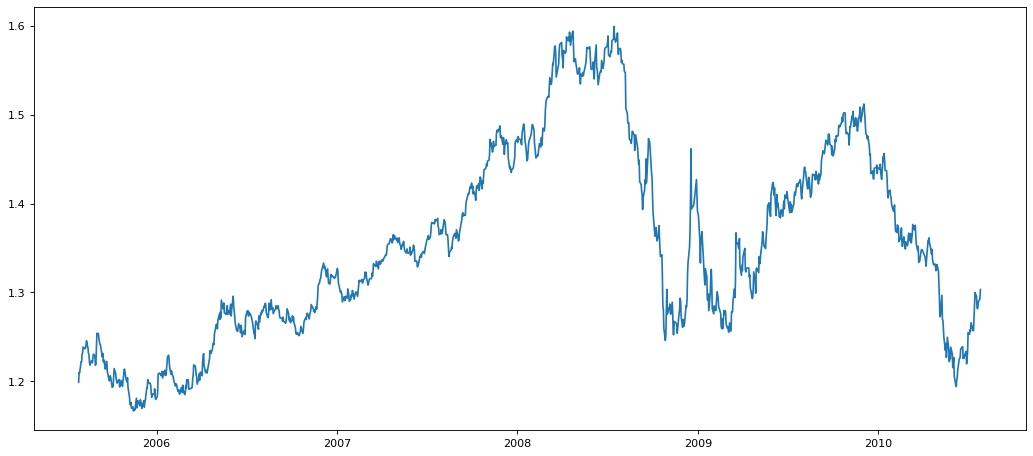

In [5]:
plt.figure(figsize=(16, 7), dpi=80)
plt.plot(dates, df['USD per Euro'])
plt.show()

# Estimating the volatility

In [6]:
n = len(r) + 1
m = len(r)

In [7]:
# The return vector (in percentage)
r_sample = r[:m]
np.round(r_sample, 5) * 100

array([ 0.917, -0.058,  1.042, ...,  0.366,  0.264,  0.789])

In [8]:
# Estimating the sample volatility: Method 1, the usual formula
r_bar = np.mean(r_sample)
v_sample = np.sum( np.power(r_sample - r_bar, 2) ) / (m-1)
sigma_sample = np.sqrt(v_sample) 
print('**** Method 1, the usual formula ***** ')
print('Average return (in percentage): ', r_bar * 100)
print('Sample variance (in 0.0001): ', v_sample * 10000)
print('Sample standard deviation (in percentage): ', sigma_sample* 100)

**** Method 1, the usual formula ***** 
Average return (in percentage):  0.008788250233523837
Sample variance (in 0.0001):  0.4525690817331787
Sample standard deviation (in percentage):  0.6727325484419338


In [9]:
# Estimating the sample volatility: Method 2, the simplified formula
v_sample = np.sum( np.power(r_sample, 2) ) / m
sigma_sample = np.sqrt(v_sample) 
print('**** Method 2, the simplified formula ***** ')
print('Sample variance (in 0.0001): ', v_sample * 10000)
print('Sample standard deviation (in percentage): ', sigma_sample* 100)

**** Method 2, the simplified formula ***** 
Sample variance (in 0.0001):  0.4522921921631916
Sample standard deviation (in percentage):  0.6725267222669978


In [10]:
# Estimating the sample volatility: Directly using numpy's std function
print("**** Numpy's std function ***** ")
print('Sample standard deviation (in percentage): ', np.std(r_sample) * 100)

**** Numpy's std function ***** 
Sample standard deviation (in percentage):  0.6724692995379227


In [11]:
v_sample = v_sample*10000

# EWMA Model Illustration

In [12]:
def get_EWMA_variance_rate (lamb):
    
    ###########
    # Evaluate the sequence of variance rate estimates under the EWMA model
    # Input: model parameter lambda
    # Output: a sequence of variance rate estimates in the same size as the return vector r
    ###########
    
    
    v = np.zeros_like(r) 

    v[0] = np.nan #discard the first entry of v 
    v[1] = r[0] * r[0] #the second entry of v

    #define v resursively under the EWMA model
    for n in range(2, len(r)):
        v[n] = lamb * v [n-1] + (1-lamb) * r[n-1] * r[n-1]
    return v


def get_EWMA_volatility (lamb):
    
    ###########
    # Evaluate the sequence of volatility estimates under the EWMA model
    # Input: model parameter lambda
    # Output: a sequence of volatility estimates in the same size as the return vector r
    ###########
    
    return np.sqrt(get_EWMA_variance_rate (lamb))

In [13]:
lamb = 0.94

print('First %d Entries of Variance Rate (in 0.0001, rounded by 3 digits):' %n)
print(np.round( get_EWMA_variance_rate (lamb) * 10000,3)[0:n]) 
print('First %d Entries of Volatility  (in 0.01, rounded by 3 digits):' %n)
print(np.round( get_EWMA_volatility (lamb) * 100,3 )[0:n]) 


First 1279 Entries of Variance Rate (in 0.0001, rounded by 3 digits):
[  nan 0.842 0.791 ... 0.546 0.521 0.494]
First 1279 Entries of Volatility  (in 0.01, rounded by 3 digits):
[  nan 0.917 0.89  ... 0.739 0.722 0.703]


# GARCH(1,1) Model Illustration

In [14]:
def get_GARCH_variance_rate (omega, alpha, beta):
    
    ###########
    # Evaluate the sequence of variance rate estimates under the GARCH(1,1) model
    # Input: model parameters omega, alpha, and beta
    # Output: a sequence of variance rate estimates in the same size as the return vector r
    ###########
    
    v = np.zeros_like(r) 

    v[0] = np.nan  #discard the first entry of v
    v[1] = r[0] * r[0] #the second entry of v

    #define v resursively under the basic GARCH (1,1) model
    for n in range(2, len(r)):
        v[n] = omega + alpha * r[n-1] * r[n-1] + beta * v[n-1] 
        
    return v


def get_GARCH_volatility (omega, alpha, beta):
    
    ###########
    # Evaluate the sequence of volatility estimates under the GARCH(1,1) model
    # Input: model parameters omega, alpha, and beta
    # Output: a sequence of volatility estimates in the same size as the return vector r
    ###########
    
        
    return np.sqrt( get_GARCH_variance_rate (omega, alpha, beta) )


In [15]:
omega = 1e-06
alpha = 0.08
beta = 0.91

print('First %d Entries of Variance Rate (by 0.0001, rounded by 3 digits):' %n)
print(np.round( get_GARCH_variance_rate (omega,alpha,beta) * 10000,3)[0:n]) 
print('First %d Entries of Volatility  (by 0.01, rounded by 3 digits):' %n)
print(np.round( get_GARCH_volatility (omega,alpha,beta) * 100,3 )[0:n]) 


First 1279 Entries of Variance Rate (by 0.0001, rounded by 3 digits):
[  nan 0.842 0.776 ... 0.575 0.544 0.51 ]
First 1279 Entries of Volatility  (by 0.01, rounded by 3 digits):
[  nan 0.917 0.881 ... 0.758 0.737 0.714]


# Implementing the Maximum Likelihood Method

In [16]:
def get_GARCH_VT_variance_rate (alpha, beta):
    
    ###########
    # Evaluate the sequence of variance rate estimates under the GARCH(1,1) model with variance targeting
    # Input: model parameters alpha, and beta
    # Output: a sequence of variance rate estimates in the same size as the return vector r
    ###########
        
    v = np.zeros_like(r) 

    v[0] = np.nan  #discard the first entry of v
    v[1] = r[0] * r[0] #the second entry of v

    #define v resursively under the basic GARCH (1,1) model
    for n in range(2, len(r)):
        v[n] =+ v_sample*(1-alpha-beta)+ alpha * r[n-1] * r[n-1] + beta * v[n-1] 
    
    return v
    


def get_GARCH_VT_volatility (alpha, beta):
    
    ###########
    # Evaluate the sequence of volatility estimates under the GARCH(1,1) model with variance targeting
    # Input: model parameters alpha, and beta
    # Output: a sequence of volatility estimates in the same size as the return vector r
    ###########
    return np.sqrt( get_GARCH_VT_variance_rate (alpha, beta) )

In [17]:
# Define the maximum likelihood method loss objective function 
# There are three modes: 'GARCH', 'EWMA', 'GARCH-VT'

def Loss(paras, mode):
    
    ###########
    # Evaluate the MLE loss function for EWMA, GARCH(1,1), and GARCH(1,1) model with variance targeting
    # Input: paras:model parameters (possibly scaled) 
    #        mode: should be one of 'GARCH', 'EWMA', or 'GARCH-VT'
    # Output: the MLE loss function value 
    ###########

    #Initialize the parameters
    
    if mode == 'GARCH':
        omega = paras[0]/100000 # The rescaling here is for numerical stability
        alpha = paras[1]/10 # The rescaling here is for numerical stability
        beta = paras[2]
        v = get_GARCH_variance_rate (omega, alpha, beta)
        
        
    if mode == 'EWMA':
        lamb = paras        
        v = get_EWMA_variance_rate (lamb)
        
        
    if mode == 'GARCH-VT':
        alpha = paras[0]/10 # The rescaling here is for numerical stability
        beta = paras[1]
        
        ########################################
        #double check that alpha + beta <= 1 to improve numerical stability
        ########################################
        if alpha + beta > 1:
            return  - np.exp(alpha + beta - 1) - 1
        ############
        v = get_GARCH_VT_variance_rate (alpha, beta)
        
        
    #delte the first entry of v for likelihood calculation, because it is empty
    v = v[1:] 
    
    # The MLE loss vector is the negative of the log likelihood (one for each data point)
    losses =  np.log(v) + r[1:]*r[1:]/v
    
    # NB:The "total" loss and "average" loss are equivalent for training purposes
    return np.nanmean(losses)

## Application to GARCH(1,1)

In [18]:
# Example: loss function value given a set of parameters
omega = 1e-06
alpha = 0.08
beta = 0.91
L = Loss ((omega*100000, alpha * 10, beta), mode = 'GARCH')

print('The loss function value when omega=%f, alpha=%f, and beta = %f: ' %(omega,alpha,beta))
print(L)


The loss function value when omega=0.000001, alpha=0.080000, and beta = 0.910000: 
-9.224363180069917


In [19]:
#Implement the Maximum Likelihood Method for GARCH(1,1)

x0 = (1, 1, 1) #Initial guess of the parameters

omega = x0[0]/100000
alpha = x0[1]/10
beta = x0[2]

print('Initial guess of the (omega, alpha, beta) configuration: ', (omega, alpha, beta))
print('Objective function value for the initial guess: ', Loss (x0, mode = 'GARCH'))

print('************')
res = opt.minimize( lambda x: Loss (x, mode = 'GARCH')  , x0, method='trust-constr', options={'disp': True})
paras_optimal =  res.x
omega = paras_optimal[0]/100000
alpha = paras_optimal[1]/10
beta = paras_optimal[2]

print('************')
print('Optimal omega: ', omega)
print('Optimal alpha: ', alpha)
print('Optimal beta: ',  beta)
print('Optimal value for the optimal solution : ', Loss (paras_optimal, mode = 'GARCH'))

Initial guess of the (omega, alpha, beta) configuration:  (1e-05, 0.1, 1)
Objective function value for the initial guess:  -5.049408251220713
************


C:\Users\tat97\AppData\Local\Temp/ipykernel_2440/3091173245.py:44: RuntimeWarning: invalid value encountered in log
  losses =  np.log(v) + r[1:]*r[1:]/v


`xtol` termination condition is satisfied.
Number of iterations: 83, function evaluations: 332, CG iterations: 179, optimality: 2.38e-07, constraint violation: 0.00e+00, execution time: 0.31 s.
************
Optimal omega:  1.3303466140359353e-07
Optimal alpha:  0.044463846156661505
Optimal beta:  0.9534328906252637
Optimal value for the optimal solution :  -9.249174265897661


long-run volatiity under basic GARCH (1,1) is:  0.7953084391127456
Simple (static) volatility:  0.6725267222669978


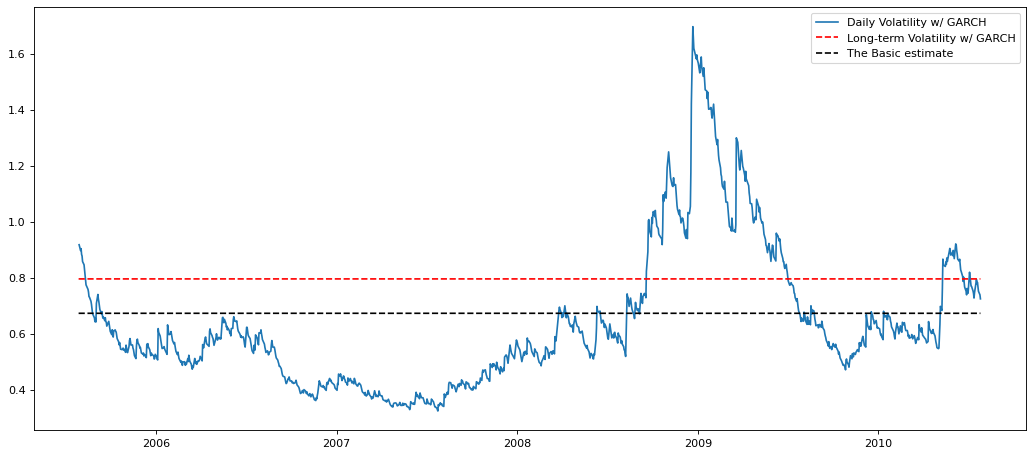

In [20]:
# Analysis and visualization of results 

#long-term variance under GARCH
VL = omega / (1 - alpha - beta )
#long-term volatility under GARCH
sigma_L = np.sqrt(VL) * 100 # measured in percentage
print('long-run volatiity under basic GARCH (1,1) is: ', sigma_L)

#Sample standard deviation: basic estimate of (static) volatility using full return data
n = len(r) + 1
m = len(r)
v_sample = np.sum( np.power(r, 2) ) / m
sigma_sample = np.sqrt(v_sample) * 100
print('Simple (static) volatility: ', sigma_sample)

#dynamic volatility under GARCH
sigma_GARCH = get_GARCH_volatility (omega, alpha, beta) * 100 # measured in percentage

plt.figure(figsize=(16, 7), dpi=80)
plt.plot(dates[1:], sigma_GARCH , label = 'Daily Volatility w/ GARCH')
plt.plot(dates[1:], sigma_L * np.ones(len(dates[1:])) , 'r--' , label = 'Long-term Volatility w/ GARCH')
plt.plot(dates[1:], sigma_sample * np.ones(len(dates[1:])) , 'k--', label = 'The Basic estimate' )
plt.legend()
plt.savefig('Q6(tats) GARCH.jpg')  
plt.show()

## EWMA 

In [21]:
#Implement the Maximum Likelihood Method for EWMA

x0 = .6 #Initial guess of lambda
print('Initial guess of the lambda: ', x0)
print('Objective function value for the initial guess: ', Loss (x0, mode = 'EWMA'))
print('************')

res = opt.minimize( lambda x: Loss (x, mode = 'EWMA')  , x0, method='trust-constr',  options={'disp': True})
paras_optimal =  res.x
lamb = paras_optimal[0]

print('************')
print('Optimal lambda: ', lamb)
print('Optimal value for the optimal solution : ', Loss (paras_optimal, mode = 'EWMA'))

Initial guess of the lambda:  0.6
Objective function value for the initial guess:  -8.847424188337962
************
`gtol` termination condition is satisfied.
Number of iterations: 15, function evaluations: 30, CG iterations: 14, optimality: 0.00e+00, constraint violation: 0.00e+00, execution time: 0.19 s.
************
Optimal lambda:  0.9583829238885544
Optimal value for the optimal solution :  -9.245478987238194


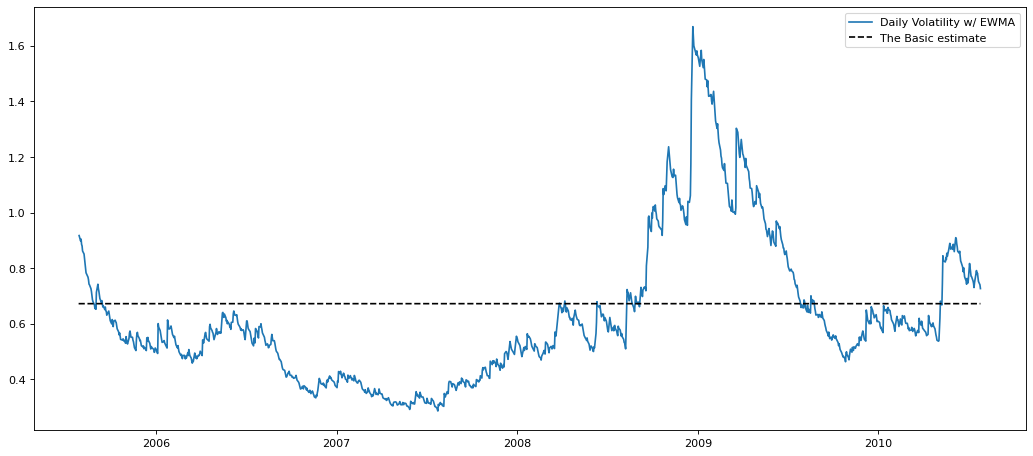

In [22]:
# Analysis and visualization of results 

#dynamic volatility under EWMA
sigma_EWMA = get_EWMA_volatility (lamb)* 100 # measured in percentage
plt.figure(figsize=(16, 7), dpi=80)
plt.plot(dates[1:], sigma_EWMA , label = 'Daily Volatility w/ EWMA')
plt.plot(dates[1:], sigma_sample * np.ones(len(dates[1:])) , 'k--', label = 'The Basic estimate' )
plt.legend()
plt.savefig('Q6(tats) EWMA.jpg') 
plt.show()

# GARCH(1,1): Variance Targeting

In [23]:
#Implement the Maximum Likelihood Method for Basic GARCH(1,1)
x0 = (0.8, 0.8) #Initial guess of omega, alpha, and beta

alpha = x0[0]/10
beta = x0[1]

print('Initial guess of the (alpha, beta) configuration: ', (alpha, beta))
print('Objective function value for the initial guess: ', Loss (x0, mode = 'GARCH-VT'))
print('************')
res = opt.minimize( lambda x: Loss (x, mode = 'GARCH-VT')  , x0, method='trust-constr',  options={'disp': True})
paras_optimal =  res.x
alpha = paras_optimal[0]/10
beta = paras_optimal[1]
print('************')
print('Optimal alpha: ', alpha)
print('Optimal beta: ',  beta)
print('Optimal value for the optimal solution : ', Loss (paras_optimal, mode = 'GARCH-VT'))

Initial guess of the (alpha, beta) configuration:  (0.08, 0.8)
Objective function value for the initial guess:  -9.173716204584244
************
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 114, CG iterations: 48, optimality: 4.77e-06, constraint violation: 0.00e+00, execution time: 0.13 s.
************
Optimal alpha:  0.04330386814487874
Optimal beta:  0.9534211613639981
Optimal value for the optimal solution :  -9.249065046819254


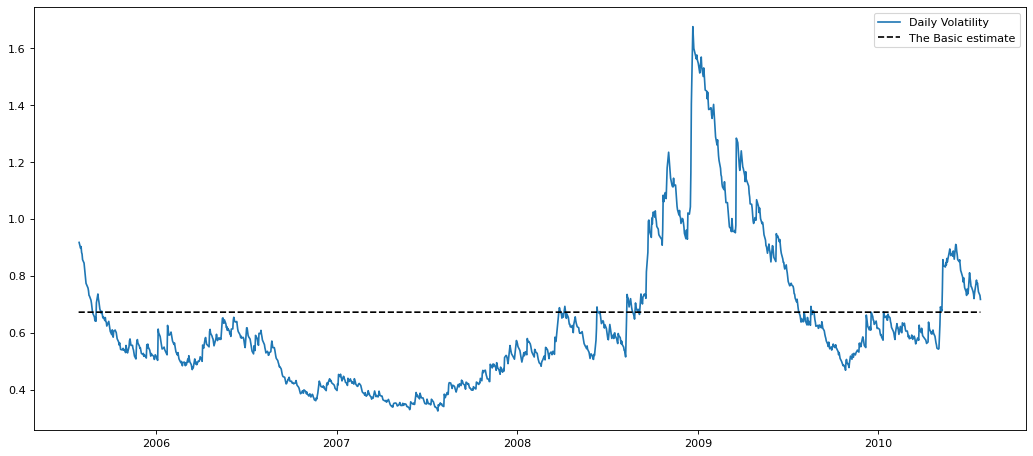

In [24]:
# Analysis and visualization of results 
#dynamic volatility under GARCH-VT
sigma_GARCH_VT = get_GARCH_VT_volatility (alpha, beta) * 100 # measured in percentage
plt.figure(figsize=(16, 7), dpi=80)
plt.plot(dates[1:], sigma_GARCH_VT , label = 'Daily Volatility')
plt.plot(dates[1:], sigma_sample * np.ones(len(dates[1:])) , 'k--', label = 'The Basic estimate' )
plt.legend()
plt.savefig('Q6(tats) GARCH-VT.jpg') 
plt.show()

# Summary Graph

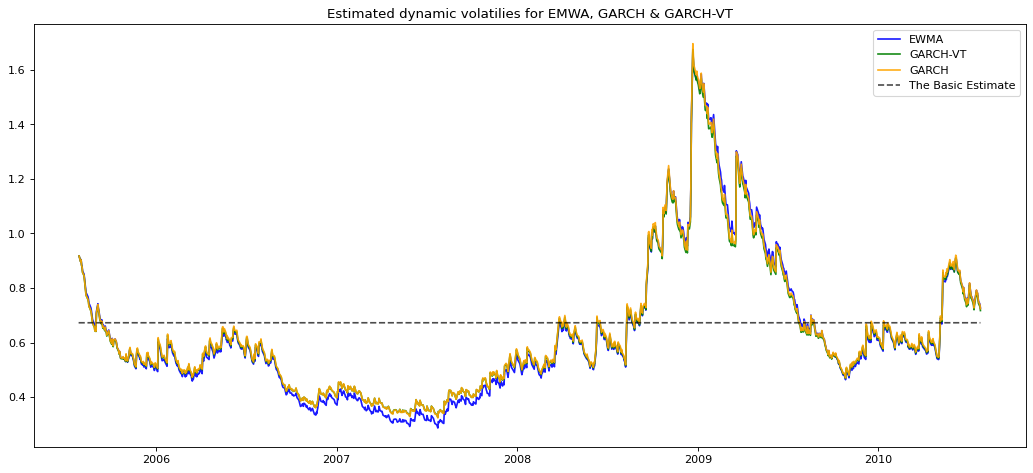

In [25]:
plt.figure(figsize=(16, 7), dpi=80)
plt.plot(dates[1:], sigma_EWMA, 'b' , label = 'EWMA', alpha = 0.9)
plt.plot(dates[1:], sigma_GARCH_VT, 'g' , label = 'GARCH-VT', alpha = 0.9)
plt.plot(dates[1:], sigma_GARCH , 'orange', label = 'GARCH', alpha = 0.9)
plt.plot(dates[1:], sigma_sample * np.ones(len(dates[1:])) , 'k--', label = 'The Basic Estimate' , alpha = 0.7)


#plt.xlim([pd.to_datetime ('2008-06-01'), pd.to_datetime ('2009-06-01')])

plt.title("Estimated dynamic volatilies for EMWA, GARCH & GARCH-VT")
plt.legend()
plt.savefig('Q6(tats) Summary Q6.jpg')

plt.show()

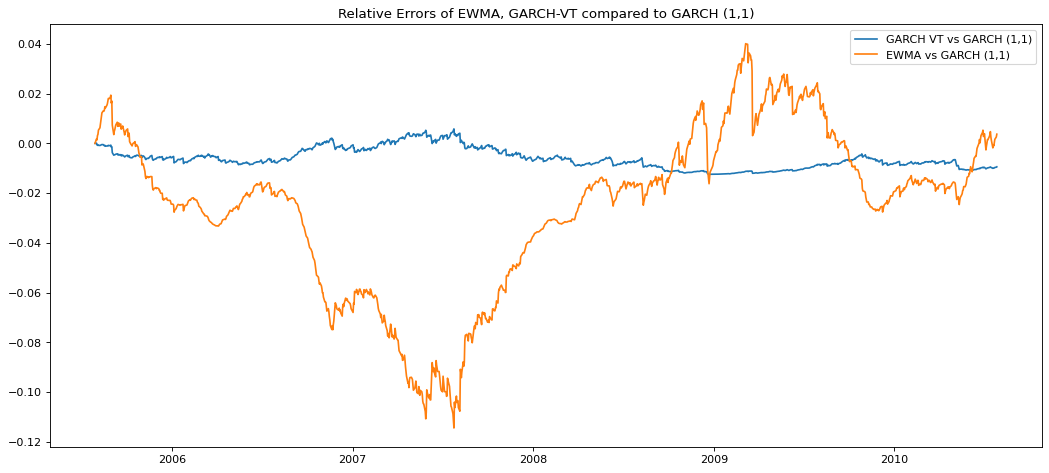

In [26]:
# Summary 2

vt_vs_gar = [(sigma_GARCH_VT[i] - sigma_GARCH[i])/sigma_GARCH[i] for i in range(len(sigma_GARCH))]
ewma_vs_gar = [(sigma_EWMA[i] - sigma_GARCH[i])/sigma_GARCH[i] for i in range(len(sigma_GARCH))]


plt.figure(figsize=(16, 7), dpi=80)
plt.plot(dates[1:], vt_vs_gar, label = 'GARCH VT vs GARCH (1,1)', color = 'tab:blue')
plt.plot(dates[1:], ewma_vs_gar, label = 'EWMA vs GARCH (1,1)', color = 'tab:orange')
plt.title("Relative Errors of EWMA, GARCH-VT compared to GARCH (1,1)")
plt.legend()
plt.savefig('Q6(tats) Summary Volatilities.jpg')
plt.show()
